In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
wti_resid = pd.ExcelFile('eta/wti_残差项_合并数据.xlsx').parse('Sheet1')
wti_resid['Date'] = pd.to_datetime(wti_resid['Date'], errors='coerce')
wti_resid = wti_resid.sort_values('Date', ascending=True)
wti_resid = wti_resid.drop(columns=['真实值'])
wti_resid = wti_resid.dropna()
wti_resid = wti_resid.rename(columns={'预测值':'wti原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值'})
wti_resid.head()

,Date,wti原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值
20,2025-10-24,-16.2
19,2025-10-27,-16.2
18,2025-10-28,-16.5
17,2025-10-29,-15.7
16,2025-10-30,-16.0


In [5]:
wti_1_4 = pd.ExcelFile('eta/WTI连1-连4月差_合并数据.xlsx').parse('Sheet1')
wti_1_4['Date'] = pd.to_datetime(wti_1_4['Date'], errors='coerce')
wti_1_4 = wti_1_4.sort_values('Date', ascending=True)
wti_1_4 = wti_1_4.drop(columns=['真实值'])
wti_1_4 = wti_1_4.dropna()
wti_1_4 = wti_1_4.rename(columns={'预测值':'WTI连1-连4月差'})
wti_1_4.head()

,Date,WTI连1-连4月差
20,2025-10-27,1.230000
19,2025-10-28,1.584283
18,2025-10-29,1.263358
17,2025-10-30,1.266859
16,2025-10-31,1.451245


In [6]:
file_path_wti = 'data_input_auto/wti原油期货价格.xlsx'
wti = pd.read_excel(file_path_wti, sheet_name='Sheet1', names=['Date', 'wti原油期货价格'])
wti['Date'] = pd.to_datetime(wti['Date'], errors='coerce')
wti = wti[wti['Date'] >= '2023-01-01']
wti.set_index('Date', inplace=True)
wti.tail()

,wti原油期货价格
Date,
2025-10-20,56.93
2025-10-21,57.58
2025-10-22,59.38
2025-10-23,61.75
2025-10-24,61.44


In [7]:
dataframes = [wti_resid, wti_1_4]  
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='inner'), dataframes)
merged_df.head()

,Date,wti原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值,WTI连1-连4月差
0,2025-10-27,-16.2,1.230000
1,2025-10-28,-16.5,1.584283
2,2025-10-29,-15.7,1.263358
3,2025-10-30,-16.0,1.266859
4,2025-10-31,-16.0,1.451245


In [8]:
merged_df['WTI原油期货价格预测'] = 4.3141 * (merged_df['WTI连1-连4月差']) + 71.6895  + merged_df['wti原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值'] -1
merged_df.head()

,Date,wti原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值,WTI连1-连4月差,WTI原油期货价格预测
0,2025-10-27,-16.2,1.230000,59.795843
1,2025-10-28,-16.5,1.584283,61.024255
2,2025-10-29,-15.7,1.263358,60.439753
3,2025-10-30,-16.0,1.266859,60.154856
4,2025-10-31,-16.0,1.451245,60.950316


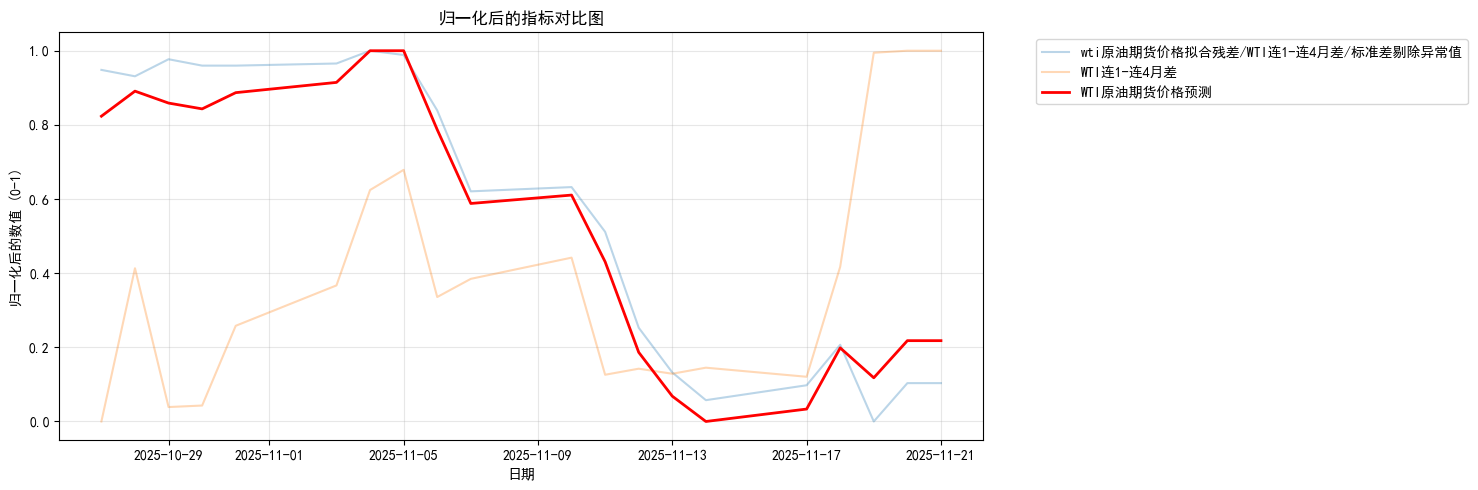

In [9]:
# 对数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler

# 创建一个新的DataFrame来存储归一化后的数据
normalized_df = merged_df.copy()

# 对每一列进行归一化处理(除了Date列)
scaler = MinMaxScaler()
columns_to_normalize = [col for col in merged_df.columns if col != 'Date']
normalized_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])

# 绘制归一化后的数据
plt.figure(figsize=(15, 5))

# 设置透明度
alpha_others = 0.3  
alpha_main = 1.0    

# 绘制每个指标
for col in normalized_df.columns:
    if col != 'Date':  
        if col == 'WTI原油期货价格预测':
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    color='red', 
                    linewidth=2,
                    alpha=alpha_main)
        else:
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    alpha=alpha_others)

plt.title('归一化后的指标对比图')
plt.xlabel('日期')
plt.ylabel('归一化后的数值 (0-1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

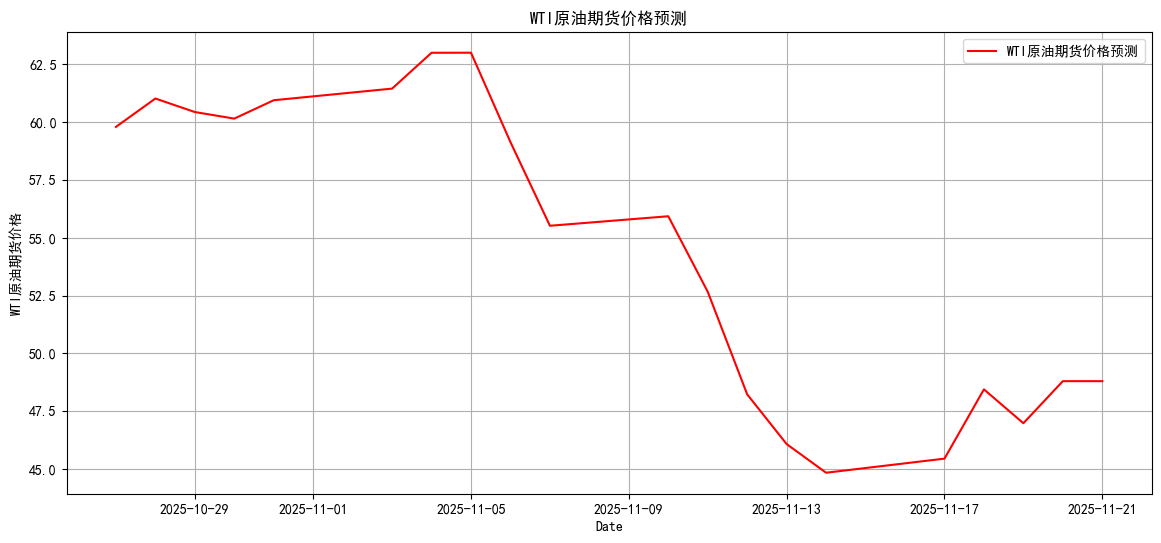

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['WTI原油期货价格预测'], label='WTI原油期货价格预测', color='red')
plt.xlabel('Date')
plt.ylabel('WTI原油期货价格')
plt.title('WTI原油期货价格预测')
plt.legend()
plt.grid(True)
plt.show()

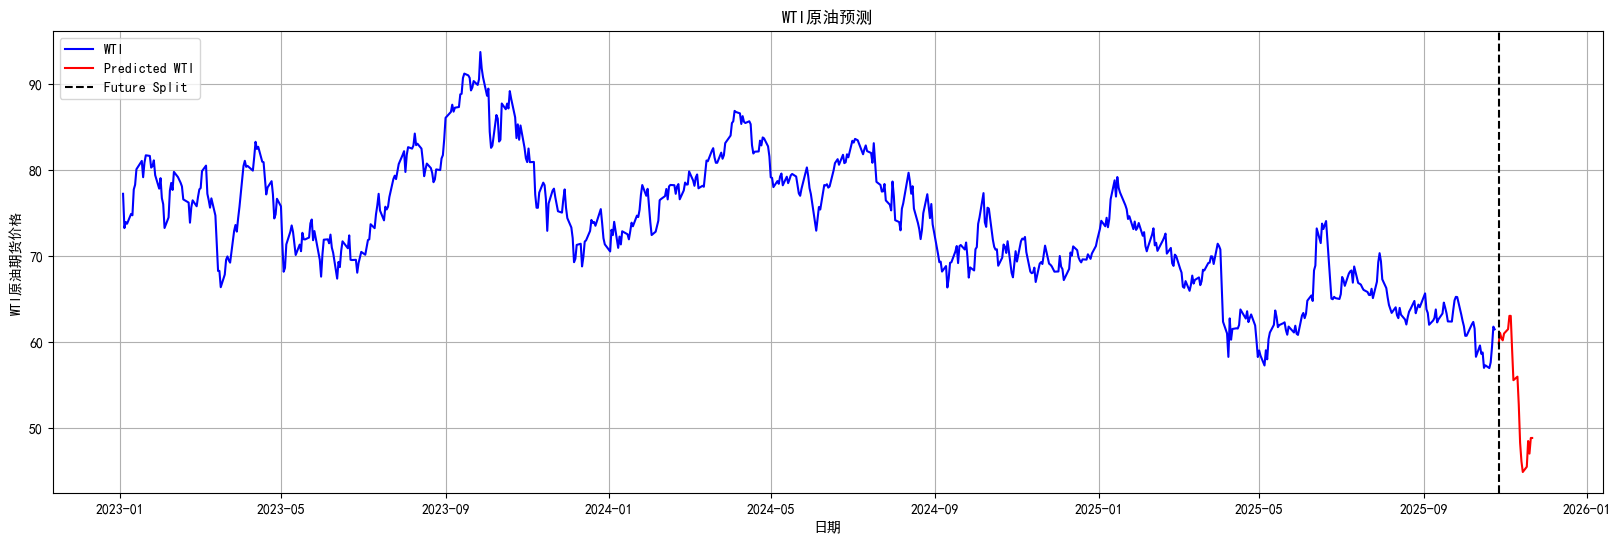

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(wti.index, wti['wti原油期货价格'], label='WTI', color='blue')
plt.plot(merged_df['Date'], merged_df['WTI原油期货价格预测'], label='Predicted WTI', color='red')

plt.axvline(x=merged_df['Date'].iloc[0], color='black', linestyle='--', label='Future Split')

plt.title('WTI原油预测')
plt.xlabel('日期')
plt.ylabel('WTI原油期货价格')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
result = merged_df[['Date','WTI原油期货价格预测']]
output_excel_file = 'data_output_auto/WTI原油期货价格预测2.xlsx'
result = result.sort_values('Date')
result.to_excel(output_excel_file, index=False)
print(result.to_string(index=False)) 

      Date  WTI原油期货价格预测
2025-10-27    59.795843
2025-10-28    61.024255
2025-10-29    60.439753
2025-10-30    60.154856
2025-10-31    60.950316
2025-11-03    61.453080
2025-11-04    63.004611
2025-11-05    63.005993
2025-11-06    59.137286
2025-11-07    55.518530
2025-11-10    55.929981
2025-11-11    52.661964
2025-11-12    48.222379
2025-11-13    46.072033
2025-11-14    44.832448
2025-11-17    45.441826
2025-11-18    48.439359
2025-11-19    46.974010
2025-11-20    48.794148
2025-11-21    48.794148


In [13]:
# 合成一个表格 让wti 真实值 和预测值 在一个表格里 日度数据
# 将wti的索引重置为普通列
wti_reset = wti.reset_index()
wti_reset.columns = ['Date', 'wti原油期货价格']

merged_df_reset = merged_df.reset_index()
wti_real_and_prediction = pd.merge(wti_reset, merged_df_reset[['Date','WTI原油期货价格预测']], on='Date', how='outer')




wti_real_and_prediction = wti_real_and_prediction.sort_values('Date', ascending=False)
wti_real_and_prediction['Date'] = pd.to_datetime(wti_real_and_prediction['Date']).dt.strftime('%Y/%m/%d')
wti_real_and_prediction.to_excel('eta/wti_合并数据.xlsx', index=False, float_format='%.2f')
wti_real_and_prediction.head()

,Date,wti原油期货价格,WTI原油期货价格预测
729,2025/11/21,NaN,48.794148
728,2025/11/20,NaN,48.794148
727,2025/11/19,NaN,46.974010
726,2025/11/18,NaN,48.439359
725,2025/11/17,NaN,45.441826


In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "WTI原油期货价格"

# 调用函数更新数据
success = update_excel_data(wti_real_and_prediction, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
wti_real_and_prediction

,Date,wti原油期货价格,WTI原油期货价格预测
729,2025/11/21,NaN,48.794148
728,2025/11/20,NaN,48.794148
727,2025/11/19,NaN,46.974010
726,2025/11/18,NaN,48.439359
725,2025/11/17,NaN,45.441826
...,...,...,...
4,2023/01/09,74.87,NaN
3,2023/01/06,73.73,NaN
2,2023/01/05,73.93,NaN
1,2023/01/04,73.22,NaN


In [16]:
count_prediction = wti_real_and_prediction.copy()
# 将实际值和预测值合并为一列
count_prediction['预测叠加'] = count_prediction['wti原油期货价格'].fillna(count_prediction['WTI原油期货价格预测'])
# 将日期列转换为datetime格式
count_prediction['Date'] = pd.to_datetime(count_prediction['Date'])
# 设置日期为索引
count_prediction.set_index('Date', inplace=True)
# 获取每月最后一天的数据
count_monthly_data = count_prediction.resample('ME').last()
# 重置索引并格式化日期
count_monthly_data = count_monthly_data.reset_index()
count_monthly_data['Date'] = count_monthly_data['Date'].dt.strftime('%Y/%m/%d')
# 显示结果
print(count_monthly_data[['Date', '预测叠加']].tail())


          Date       预测叠加
30  2025/07/31  69.360000
31  2025/08/31  64.010000
32  2025/09/30  62.430000
33  2025/10/31  60.950316
34  2025/11/30  48.794148
